In [1]:
import os
import pandas as pd
import torch
import json
import torch.nn as nn

import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [14]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sathk\AppData\Roaming\nltk_data...


True

In [15]:
price_folder = "data/stocknet-dataset/price/raw"
tweet_folder = "data/stocknet-dataset/tweet/preprocessed"

symbols = np.sort(os.listdir(tweet_folder))
print(symbols, len(symbols))

['AAPL' 'ABB' 'ABBV' 'AEP' 'AGFS' 'AMGN' 'AMZN' 'BA' 'BABA' 'BAC' 'BBL'
 'BCH' 'BHP' 'BP' 'BRK-A' 'BSAC' 'BUD' 'C' 'CAT' 'CELG' 'CHL' 'CHTR'
 'CMCSA' 'CODI' 'CSCO' 'CVX' 'D' 'DHR' 'DIS' 'DUK' 'EXC' 'FB' 'GD' 'GE'
 'GOOG' 'HD' 'HON' 'HRG' 'HSBC' 'IEP' 'INTC' 'JNJ' 'JPM' 'KO' 'LMT' 'MA'
 'MCD' 'MDT' 'MMM' 'MO' 'MRK' 'MSFT' 'NEE' 'NGG' 'NVS' 'ORCL' 'PCG' 'PCLN'
 'PEP' 'PFE' 'PG' 'PICO' 'PM' 'PPL' 'PTR' 'RDS-B' 'REX' 'SLB' 'SNP' 'SNY'
 'SO' 'SPLP' 'SRE' 'T' 'TM' 'TOT' 'TSM' 'UL' 'UN' 'UNH' 'UPS' 'UTX' 'V'
 'VZ' 'WFC' 'WMT' 'XOM'] 87


# RUN BELOW CELL ONLY ONCE

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer

def embedTweets(tweets):
    if not tweets:
        return [0, 0.0]
    sia = SentimentIntensityAnalyzer()
    sentiments = [sia.polarity_scores(tweet)['compound'] for tweet in tweets]
    return [len(sentiments), np.mean(sentiments)]

In [20]:
for symbol in tqdm(symbols):
    print(symbol)
    tweet_dates = np.array(os.listdir(tweet_folder + "/" + symbol))
    start_date = tweet_dates[0]
    end_date = tweet_dates[-1]

    df = pd.read_csv(price_folder + "/" + symbol + ".csv")
    std = np.nanstd(df[df["Date"] >= start_date]["Open"].values)
    mean = np.nanmean(df[df["Date"] >= start_date]["Open"].values)
    print(std, mean)
    
    input_df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    price_dates = input_df["Date"].values
    target_df = df[(df["Date"] > end_date)]

    tweet_data = dict()
    idx = 0
    tweet_data[price_dates[idx]] = list()
    for date in tqdm(tweet_dates):
        if date < price_dates[idx]:
            continue
        elif date >= price_dates[idx] and ((idx < len(price_dates) - 1) and (date < price_dates[idx + 1])):
            with open(tweet_folder + "/" + symbol + "/" + date, "r") as file:
                tweet_data[price_dates[idx]] += [" ".join(eval(tweet[:-1])['text']) for tweet in file.readlines()]
        else:
            while (idx < len(price_dates) - 1) and (date >= price_dates[idx + 1]):
                idx += 1
                tweet_data[price_dates[idx]] = list()

            with open(tweet_folder + "/" + symbol + "/" + date, "r") as file:
                tweet_data[price_dates[idx]] += [" ".join(eval(tweet[:-1])['text']) for tweet in file.readlines()]

    input_data = dict()
    for date in price_dates:
        input_data[date] = {"price": input_df[input_df["Date"] == date]["Open"].values[0],
                            "tweets": embedTweets(tweet_data[date])}

    target_data = dict()
    for date in target_df["Date"].values:
        target_data[date] = {"price": target_df[target_df["Date"] == date]["Open"].values[0]}

    out_data = {"input": input_data, "target": target_data}
    with open(f"data/processed_data_sentiment/{symbol}.json", 'w') as fp:
        json.dump(out_data, fp)

  0%|          | 0/87 [00:00<?, ?it/s]

AAPL
20.661986991378562 112.54634296432434


  0%|          | 0/696 [00:00<?, ?it/s]

ABB
2.219937370225223 21.607260613585744


  0%|          | 0/71 [00:00<?, ?it/s]

ABBV
6.084027129268579 60.75503242748918


  0%|          | 0/382 [00:00<?, ?it/s]

AEP
6.514486680286598 59.7188000345946


  0%|          | 0/142 [00:00<?, ?it/s]

AGFS
1.8848155463363823 5.734403100775193


  0%|          | 0/2 [00:00<?, ?it/s]

AMGN
17.52003519211682 151.76472455783784


  0%|          | 0/398 [00:00<?, ?it/s]

AMZN
226.47036609444552 579.4386272486487


  0%|          | 0/671 [00:00<?, ?it/s]

BA
25.53869904719407 145.13985958054056


  0%|          | 0/441 [00:00<?, ?it/s]

BABA
22.579361024468884 94.25816502416106


  0%|          | 0/446 [00:00<?, ?it/s]

BAC
3.372490370440805 17.509167596756757


  0%|          | 0/588 [00:00<?, ?it/s]

BBL
14.381994226179762 39.743514126898056


  0%|          | 0/75 [00:00<?, ?it/s]

BCH
6.924560290467329 68.63718972502937


  0%|          | 0/9 [00:00<?, ?it/s]

BHP
14.924733698747291 43.59263779351351


  0%|          | 0/230 [00:00<?, ?it/s]

BP
6.3984737488321475 38.39767572756757


  0%|          | 0/336 [00:00<?, ?it/s]

BRK-A
22741.012058363183 216631.63406593408


  0%|          | 0/13 [00:00<?, ?it/s]

BSAC
2.7702906608937607 21.645148502750274


  0%|          | 0/14 [00:00<?, ?it/s]

BUD
8.23573381806019 115.80909575925925


  0%|          | 0/127 [00:00<?, ?it/s]

C
6.605604355349375 52.17859458702703


  0%|          | 0/618 [00:00<?, ?it/s]

CAT
13.57765968039339 88.92717834486486


  0%|          | 0/428 [00:00<?, ?it/s]

CELG
16.33325298280942 107.96476186904762


  0%|          | 0/476 [00:00<?, ?it/s]

CHL
5.966110273042599 57.36147192532467


  0%|          | 0/127 [00:00<?, ?it/s]

CHTR
70.55961603287855 213.18291908972972


  0%|          | 0/185 [00:00<?, ?it/s]

CMCSA
4.3722426187061245 30.983900312026005


  0%|          | 0/347 [00:00<?, ?it/s]

CODI
1.017160455451528 16.97281520652174


  0%|          | 0/32 [00:00<?, ?it/s]

CSCO
3.2004402152120726 27.91348108864865


  0%|          | 0/514 [00:00<?, ?it/s]

CVX
12.784497941506078 106.10042165621621


  0%|          | 0/462 [00:00<?, ?it/s]

D
3.7032306156913166 72.44383776756757


  0%|          | 0/638 [00:00<?, ?it/s]

DHR
9.562091259835334 69.8271684627027


  0%|          | 0/120 [00:00<?, ?it/s]

DIS
11.12967155910275 98.77365402054055


  0%|          | 0/512 [00:00<?, ?it/s]

DUK
5.3955154466634125 77.04272422162161


  0%|          | 0/160 [00:00<?, ?it/s]

EXC
2.7995199670321536 33.63316021861472


  0%|          | 0/172 [00:00<?, ?it/s]

FB
29.749763139412423 101.72340545513514


  0%|          | 0/692 [00:00<?, ?it/s]

GD
26.92749432414589 145.77260530702705


  0%|          | 0/207 [00:00<?, ?it/s]

GE
2.295216127153999 27.836572936216218


  0%|          | 0/540 [00:00<?, ?it/s]

GOOG
131.39400991759237 680.9713764248648


  0%|          | 0/680 [00:00<?, ?it/s]

HD
23.400600135210126 117.44862708324324


  0%|          | 0/402 [00:00<?, ?it/s]

HON
13.160763324855473 107.14082298374863


  0%|          | 0/181 [00:00<?, ?it/s]

HRG
2.1832496137697084 13.992697364035088


  0%|          | 0/33 [00:00<?, ?it/s]

HSBC
6.840921085079132 43.19488497590362


  0%|          | 0/82 [00:00<?, ?it/s]

IEP
22.069892840614024 75.42276503387978


  0%|          | 0/68 [00:00<?, ?it/s]

INTC
3.5077347939587007 32.61324320972973


  0%|          | 0/566 [00:00<?, ?it/s]

JNJ
11.491096400419934 108.57228105297298


  0%|          | 0/498 [00:00<?, ?it/s]

JPM
11.49365192361838 67.27263785405407


  0%|          | 0/548 [00:00<?, ?it/s]

KO
2.027487315361832 42.16098373513513


  0%|          | 0/480 [00:00<?, ?it/s]

LMT
40.08775338050036 216.4210608279221


  0%|          | 0/267 [00:00<?, ?it/s]

MA
14.640327986033334 94.04829308648648


  0%|          | 0/369 [00:00<?, ?it/s]

MCD
18.158727929393354 111.97209100975081


  0%|          | 0/491 [00:00<?, ?it/s]

MDT
8.697399158720486 74.58384858702702


  0%|          | 0/227 [00:00<?, ?it/s]

MMM
20.51422525431498 163.04787017081082


  0%|          | 0/312 [00:00<?, ?it/s]

MO
11.325909581803167 56.618528166666664


  0%|          | 0/309 [00:00<?, ?it/s]

MRK
4.0929871072435775 58.268281017297305


  0%|          | 0/421 [00:00<?, ?it/s]

MSFT
9.872164705974122 51.731156846486485


  0%|          | 0/640 [00:00<?, ?it/s]

NEE
15.39817618641541 111.38043301948053


  0%|          | 0/158 [00:00<?, ?it/s]

NGG
5.471105585113132 73.82554492216218


  0%|          | 0/34 [00:00<?, ?it/s]

NVS
9.799716733605882 85.77123506283857


  0%|          | 0/204 [00:00<?, ?it/s]

ORCL
3.285991245926078 40.973225139610385


  0%|          | 0/360 [00:00<?, ?it/s]

PCG
7.826114760269783 55.27522200108343


  0%|          | 0/140 [00:00<?, ?it/s]

PCLN
239.2212053788128 1352.1392529935135


  0%|          | 0/572 [00:00<?, ?it/s]

PEP
9.31002711106811 99.30297609740259


  0%|          | 0/300 [00:00<?, ?it/s]

PFE
1.9552261323697966 32.46209727027027


  0%|          | 0/465 [00:00<?, ?it/s]

PG
5.04164302028403 83.11279827114967


  0%|          | 0/379 [00:00<?, ?it/s]

PICO
4.858700073386084 15.474855244988865


  0%|          | 0/16 [00:00<?, ?it/s]

PM
11.59677888625856 92.1357838572973


  0%|          | 0/187 [00:00<?, ?it/s]

PPL
2.9927894469550416 33.85234024511931


  0%|          | 0/128 [00:00<?, ?it/s]

PTR
24.94261723492832 90.15550214192139


  0%|          | 0/47 [00:00<?, ?it/s]

RDS-B
7.184509351476704 56.14698339669422


  0%|          | 0/3 [00:00<?, ?it/s]

REX
16.933249493607228 69.59858721081677


  0%|          | 0/73 [00:00<?, ?it/s]

SLB
12.001395412592853 83.69174060108108


  0%|          | 0/275 [00:00<?, ?it/s]

SNP
10.657450574018629 77.72092589324619


  0%|          | 0/30 [00:00<?, ?it/s]

SNY
5.146231539246228 46.64889488299025


  0%|          | 0/171 [00:00<?, ?it/s]

SO
3.2676416751823267 47.0236972681081


  0%|          | 0/202 [00:00<?, ?it/s]

SPLP
1.6007729692600021 16.583483944114153


  0%|          | 0/8 [00:00<?, ?it/s]

SRE
6.65174798533152 104.17943355228758


  0%|          | 0/92 [00:00<?, ?it/s]

T
3.091868254022773 36.57121081837838


  0%|          | 0/684 [00:00<?, ?it/s]

TM
10.03324135558826 117.62971899567569


  0%|          | 0/140 [00:00<?, ?it/s]

TOT
7.552464859220394 52.91312775324675


  0%|          | 0/122 [00:00<?, ?it/s]

TSM
5.181525476831188 25.176547601731603


  0%|          | 0/106 [00:00<?, ?it/s]

UL
4.34698301807769 44.67144088407367


  0%|          | 0/67 [00:00<?, ?it/s]

UN
4.9225175516696815 44.16123771084337


  0%|          | 0/74 [00:00<?, ?it/s]

UNH
32.829241240654156 123.33925414162162


  0%|          | 0/336 [00:00<?, ?it/s]

UPS
5.917058133975445 103.63593716143012


  0%|          | 0/237 [00:00<?, ?it/s]

UTX
9.327110593671092 108.57728646918919


  0%|          | 0/267 [00:00<?, ?it/s]

V
13.418967869472405 72.4454703027027


  0%|          | 0/484 [00:00<?, ?it/s]

VZ
2.6605123652496347 48.84044369588745


  0%|          | 0/461 [00:00<?, ?it/s]

WFC
3.56217537682128 51.97243248108108


  0%|          | 0/439 [00:00<?, ?it/s]

WMT
6.571074951958388 73.28105938702703


  0%|          | 0/485 [00:00<?, ?it/s]

XOM
7.617682712546338 87.48432435891891


  0%|          | 0/520 [00:00<?, ?it/s]

### Utils

In [21]:
def getDataBySymbol(symbol):
    with open(f"data/processed_data_sentiment/{symbol}.json", 'r') as fp:
        data = json.load(fp)
    return data

### Train/Val/Test Split by Symbol

In [22]:
np.random.seed(111)

In [23]:
def splitDataBySymbol():
    rand_idx = np.arange(0, 87)
    np.random.shuffle(rand_idx)

    train_symbols = symbols[rand_idx[:58]]
    val_symbols = symbols[rand_idx[58:73]]
    test_symbols = symbols[rand_idx[73:]]
    return train_symbols, val_symbols, test_symbols

In [24]:
train_symbols, val_symbols, test_symbols = splitDataBySymbol()
train_symbols = np.delete(train_symbols, -1)
print(train_symbols, "\n")
print(val_symbols, "\n")
print(test_symbols)

['UPS' 'SO' 'MSFT' 'CVX' 'TM' 'MO' 'CAT' 'D' 'LMT' 'GD' 'BSAC' 'BUD' 'MDT'
 'NEE' 'HON' 'ABBV' 'UL' 'CHL' 'PTR' 'PG' 'UNH' 'SLB' 'CODI' 'AMGN' 'PICO'
 'MCD' 'AEP' 'UTX' 'NGG' 'ABB' 'AAPL' 'DHR' 'BABA' 'ORCL' 'PCG' 'EXC' 'PM'
 'T' 'SRE' 'V' 'MMM' 'SNY' 'BCH' 'PFE' 'TOT' 'C' 'UN' 'SNP' 'PPL' 'HSBC'
 'GE' 'VZ' 'JPM' 'BAC' 'IEP' 'DUK' 'HD'] 

['CMCSA' 'KO' 'MRK' 'BP' 'AMZN' 'CSCO' 'FB' 'MA' 'TSM' 'PEP' 'HRG' 'NVS'
 'CHTR' 'GOOG' 'BRK-A'] 

['DIS' 'RDS-B' 'BBL' 'BHP' 'BA' 'PCLN' 'SPLP' 'INTC' 'REX' 'JNJ' 'CELG'
 'WMT' 'XOM' 'WFC']


### Batch Sampler

In [36]:
def sampleBatch(symbols, time_horizon):
    X_price = list()
    X_tweets = list()
    log_X_dates = list()
    
    Y_price = list()
    log_Y_dates = list()
    
    for symbol in symbols:
        this_X_price = list()
        this_X_tweets = list()
        this_log_X_dates = list()
        
        this_Y_price = list()
        this_log_Y_dates = list()
        
        data = getDataBySymbol(symbol)
        all_dates = np.sort(list(data["input"].keys()))
        try:
            possible_start_dates = all_dates[:-time_horizon]
            start_date = np.random.choice(possible_start_dates)
        except:
            print(symbol)
            print(data)
        
        idx = np.where(all_dates == start_date)[0][0]
        for _ in range(time_horizon):
            date_key = all_dates[idx]
            this_X_price.append(data["input"][date_key]["price"])
            this_X_tweets.append(data["input"][date_key]["tweets"])
            this_log_X_dates.append(date_key)
            idx += 1
        
        probe_targets = False
        for _ in range(time_horizon):
            if idx >= len(all_dates):
                probe_targets = True
            else:
                date_key = all_dates[idx]
                this_Y_price.append(data["input"][date_key]["price"])
                this_log_Y_dates.append(date_key)
                idx += 1
        
        if probe_targets:
            idx = 0
            all_dates = np.sort(list(data["target"].keys()))
            for _ in range(time_horizon - len(this_Y_price)):
                date_key = all_dates[idx]
                this_Y_price.append(data["target"][date_key]["price"])
                this_log_Y_dates.append(date_key)
                idx += 1
        
        X_price.append(np.array(this_X_price))
        X_tweets.append(np.array([this_X_tweets]))
        log_X_dates.append(this_log_X_dates)
        
        Y_price.append(np.array(this_Y_price))
        log_Y_dates.append(this_log_Y_dates)
    
    X_price = np.vstack(X_price)
    X_tweets = np.vstack(X_tweets)
    Y_price = np.vstack(Y_price)
    return (X_price, X_tweets, log_X_dates), (Y_price, log_Y_dates)

In [37]:
(X_price, X_tweets, log_X_dates), (Y_price, log_Y_dates) = sampleBatch(train_symbols, 10)

In [38]:
X_price.shape, X_tweets.shape, Y_price.shape

((57, 10), (57, 10, 2), (57, 10))

In [40]:
X_price[0], X_tweets[0], Y_price[0]

(array([98.489998, 98.489998, 98.349998, 97.190002, 98.080002, 97.919998,
        97.239998, 98.949997, 99.      , 97.059998]), array([[0.    , 0.    ],
        [1.    , 0.4215],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [1.    , 0.5859],
        [0.    , 0.    ]]), array([ 99.75    , 101.900002, 101.989998, 102.209999, 103.379997,
        103.580002, 103.650002, 103.349998, 103.349998, 104.059998]))

### Additional Utils

In [41]:
var_map = dict()

for symbol in symbols:
    data = getDataBySymbol(symbol)
    all_prices = [data["input"][d]["price"] for d in data["input"]] + [data["target"][d]["price"] for d in data["target"]]
    var_map[symbol] = np.nanvar(all_prices)

### Modeling Utils

In [71]:
def computeFinalLoss(model, symbols, time_horizon, test_horizons):
    model.eval()
    
    mean_loss = {test_horizon: list() for test_horizon in test_horizons}
    cumulative_mean = {test_horizon: list() for test_horizon in test_horizons}
    norm_var = np.array([var_map[symbol] for symbol in symbols])
    
    for test_step in tqdm(range(700)):
        (X_price, X_tweets, _), (Y_price, _) = sampleBatch(symbols, time_horizon)

        X_price = torch.tensor(X_price).float()
        X_tweets = torch.tensor(X_tweets).float()
        pred_Y_price = model(X_price, X_tweets)
        pred_Y_price = pred_Y_price.detach().numpy()
        
        for idx, test_horizon in enumerate(test_horizons):
            actual_Y_price = Y_price[:, test_horizon - 1]

            h_pred_Y_price = pred_Y_price[:, idx]

            loss = np.mean(((actual_Y_price - h_pred_Y_price) ** 2) / norm_var)
            mean_loss[test_horizon].append(loss)
            cumulative_mean[test_horizon].append(np.mean(mean_loss[test_horizon]))

        if (test_step % 100 == 0):
            plt.figure(figsize=(10, 8))
            for test_horizon in cumulative_mean:
                plt.plot(cumulative_mean[test_horizon], label=test_horizon)
            plt.legend()
            plt.show()
    
    print(f"FINAL LOSS (forecast=zero-order, time_horizon={time_horizon})")
    all_loss = dict()
    for test_horizon in mean_loss:
        all_loss[test_horizon] = np.mean(mean_loss[test_horizon])
        print(test_horizon, ":", all_loss[test_horizon])
    
    return all_loss

In [72]:
def validateModel(model, symbols, time_horizon, test_horizons):
    model.eval()
    
    mean_loss = {test_horizon: list() for test_horizon in test_horizons}
    cumulative_mean = {test_horizon: list() for test_horizon in test_horizons}
    norm_var = np.array([var_map[symbol] for symbol in symbols])
    
    for test_step in tqdm(range(300)):
        (X_price, X_tweets, _), (Y_price, _) = sampleBatch(symbols, time_horizon)

        X_price = torch.tensor(X_price).float()
        X_tweets = torch.tensor(X_tweets).float()
        pred_Y_price = model(X_price, X_tweets)
        pred_Y_price = pred_Y_price.detach().numpy()
        
        for idx, test_horizon in enumerate(test_horizons):
            actual_Y_price = Y_price[:, test_horizon - 1]

            h_pred_Y_price = pred_Y_price[:, idx]

            loss = np.mean(((actual_Y_price - h_pred_Y_price) ** 2) / norm_var)
            mean_loss[test_horizon].append(loss)
            cumulative_mean[test_horizon].append(np.mean(mean_loss[test_horizon]))
    
    print(f"FINAL LOSS (forecast=zero-order, time_horizon={time_horizon})")
    all_loss = dict()
    for test_horizon in mean_loss:
        all_loss[test_horizon] = np.mean(mean_loss[test_horizon])
        print(test_horizon, ":", all_loss[test_horizon])
    
    return all_loss

In [73]:
def trainModel(model, train_losses, val_losses, best_val, optimizer, time_horizon, test_horizons, val_freq, folder_name):
    model.train()
    
    norm_var = torch.tensor([var_map[symbol] for symbol in train_symbols])
    norm_var = norm_var.repeat(len(test_horizons), 1).transpose(0, 1).float()

    for train_step in tqdm(range(5000)):
        (X_price, X_tweets, _), (Y_price, _) = sampleBatch(train_symbols, time_horizon)
        X_tweets = torch.tensor(X_tweets).float()
        X_price, Y_price = torch.tensor(X_price).float(), torch.tensor([Y_price[:, i - 1] for i in test_horizons]).float()
        Y_price = torch.transpose(Y_price, 0, 1)
        
        pred_Y_price = model(X_price, X_tweets)
    
        horizon_loss = torch.mean(((Y_price - pred_Y_price) ** 2) / norm_var, 0)
        total_loss = torch.sum(horizon_loss)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_losses.append(total_loss.item())

        if (train_step % val_freq == 0): ###
            model.eval()

            all_loss = validateModel(model, val_symbols, time_horizon, test_horizons)
            cur_val = 0.0
            for test_horizon in all_loss:
                val_losses[test_horizon].append(all_loss[test_horizon])
                cur_val += all_loss[test_horizon]
            
            if cur_val < best_val[0]:
                best_val[0] = cur_val
                torch.save(model, "models/" + folder_name + "/best.ckpt")
                print(f"saved checkpoint: {cur_val}")

            model.train()

            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_losses[50:]) ###
            plt.subplot(1, 2, 2)
            for symbol in test_horizons:
                plt.plot(val_losses[symbol][1:], label=symbol) ###
            plt.legend()
            plt.show()

        if (train_step % 10 == 0):
            print("Step: {}...".format(train_step),
                "Loss: {:.6f}...".format(np.mean(train_losses[-10:])))

### Method 6: LSTM

In [74]:
class LSTMModel(nn.Module):
    def __init__(self, inp_size, hidden_size, n_layers, out_size):
        super(LSTMModel, self).__init__()
        
        self.emb = nn.Linear(3, hidden_size)
        
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=n_layers
        )
        
        self.lin = nn.Linear(hidden_size * inp_size, out_size)

    def forward(self, X, X_tweets):
        mean = torch.mean(X, -1).unsqueeze(-1).detach()
        std = torch.std(X, -1).unsqueeze(-1).detach()
            
        X = (X - mean) / std
        X = torch.cat((X.unsqueeze(-1), X_tweets), dim=-1)
        
        emb_X = self.emb(X)
        out, (h, c) = self.lstm(emb_X)
        out = out.flatten(1)
        out = self.lin(out)
        
        out = out * std + mean
        return out

#### Time Horizon = 10, Test Horizons = (1, 2, 3, 5, 7, 10)

In [75]:
lstm_model10 = LSTMModel(10, 256, 2, 6)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(lstm_model10))

1069062


In [76]:
train_losses = list()
val_losses = {i: list() for i in [1, 2, 3, 5, 7, 10]}
best_val = [np.inf]

In [77]:
optimizer = optim.Adam(lstm_model10.parameters(), lr = 0.0005)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.03252383498440403
2 : 0.04076596783920388
3 : 0.05239959130374764
5 : 0.06454511176823724
7 : 0.08130499560684264
10 : 0.09840877790717163
saved checkpoint: 0.36994827940960706


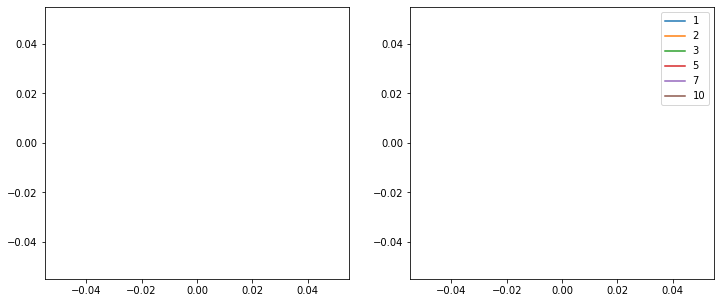

Step: 0... Loss: 0.613105...
Step: 10... Loss: 0.547421...
Step: 20... Loss: 0.610969...
Step: 30... Loss: 0.432361...
Step: 40... Loss: 0.404972...
Step: 50... Loss: 0.435482...
Step: 60... Loss: 0.330543...
Step: 70... Loss: 0.422799...
Step: 80... Loss: 0.372197...
Step: 90... Loss: 0.371862...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.012301273321193696
2 : 0.020075927565432573
3 : 0.029444971774323807
5 : 0.049852195803989335
7 : 0.0680270358462503
10 : 0.08701530893002415
saved checkpoint: 0.2667167132412139


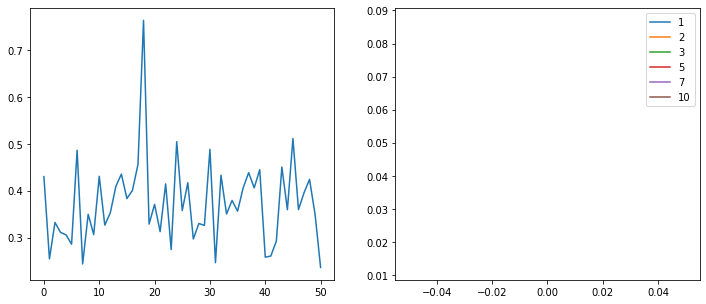

Step: 100... Loss: 0.363912...
Step: 110... Loss: 0.380924...
Step: 120... Loss: 0.413569...
Step: 130... Loss: 0.404316...
Step: 140... Loss: 0.402647...
Step: 150... Loss: 0.481430...
Step: 160... Loss: 0.348672...
Step: 170... Loss: 0.372636...
Step: 180... Loss: 0.365775...
Step: 190... Loss: 0.345560...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.011840748266614687
2 : 0.022078266770063106
3 : 0.030488140884928634
5 : 0.048246237645812
7 : 0.06616890269002046
10 : 0.08964308924834617


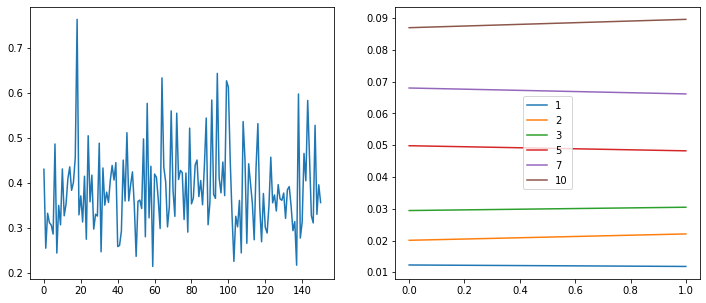

Step: 200... Loss: 0.415457...
Step: 210... Loss: 0.404384...
Step: 220... Loss: 0.360969...
Step: 230... Loss: 0.385584...
Step: 240... Loss: 0.425007...
Step: 250... Loss: 0.347352...
Step: 260... Loss: 0.398218...
Step: 270... Loss: 0.384146...
Step: 280... Loss: 0.353735...
Step: 290... Loss: 0.354049...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.012140113807401366
2 : 0.021364879625819917
3 : 0.02947095222808329
5 : 0.04773295427395819
7 : 0.06092913015249181
10 : 0.0827829582962898
saved checkpoint: 0.25442098838404437


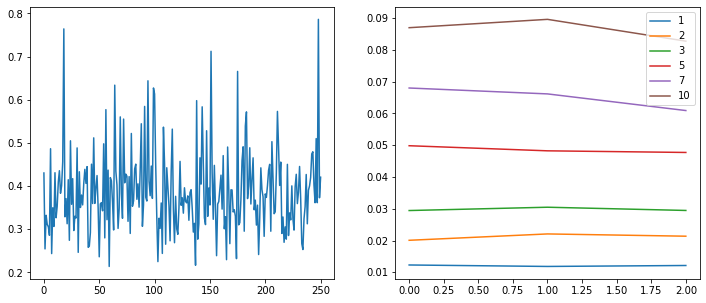

Step: 300... Loss: 0.458818...
Step: 310... Loss: 0.337841...
Step: 320... Loss: 0.378964...
Step: 330... Loss: 0.402580...
Step: 340... Loss: 0.330466...
Step: 350... Loss: 0.348815...
Step: 360... Loss: 0.388517...
Step: 370... Loss: 0.380230...
Step: 380... Loss: 0.369682...
Step: 390... Loss: 0.427345...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.011020108407204429
2 : 0.02206474805795088
3 : 0.03168088601247628
5 : 0.04858302961317696
7 : 0.06557140243090195
10 : 0.08909819166814605


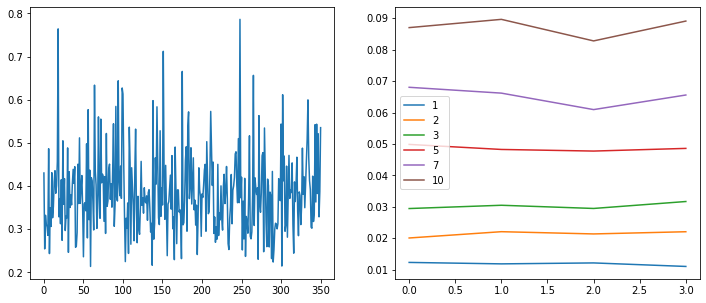

Step: 400... Loss: 0.425703...
Step: 410... Loss: 0.429604...
Step: 420... Loss: 0.383347...
Step: 430... Loss: 0.337992...
Step: 440... Loss: 0.379225...
Step: 450... Loss: 0.371218...


KeyboardInterrupt: 

In [78]:
trainModel(lstm_model10, train_losses, val_losses, best_val, optimizer, 10, [1, 2, 3, 5, 7, 10], 100, "lstm10")

  0%|          | 0/700 [00:00<?, ?it/s]

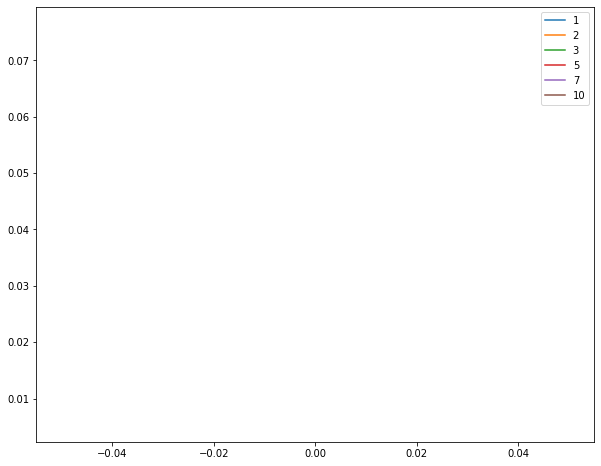

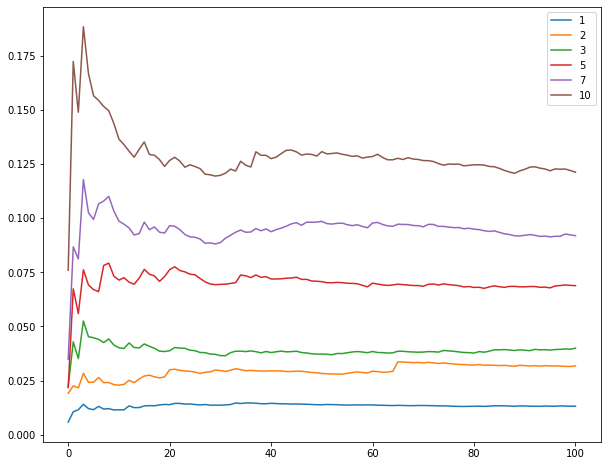

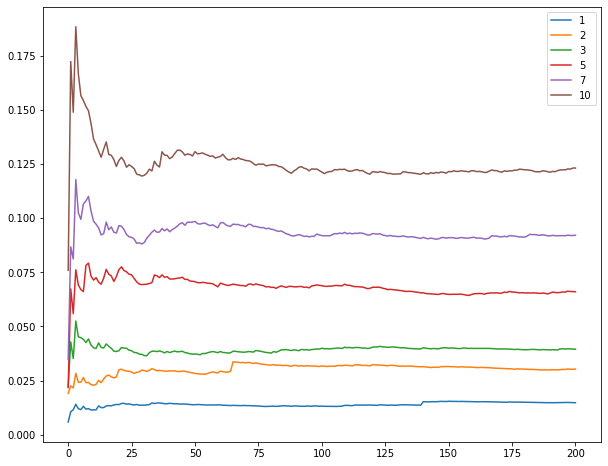

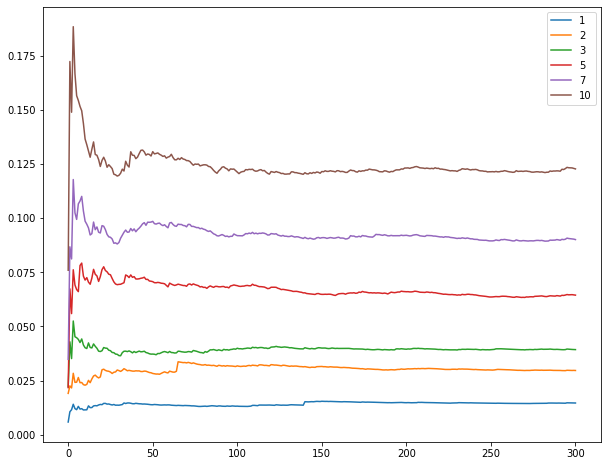

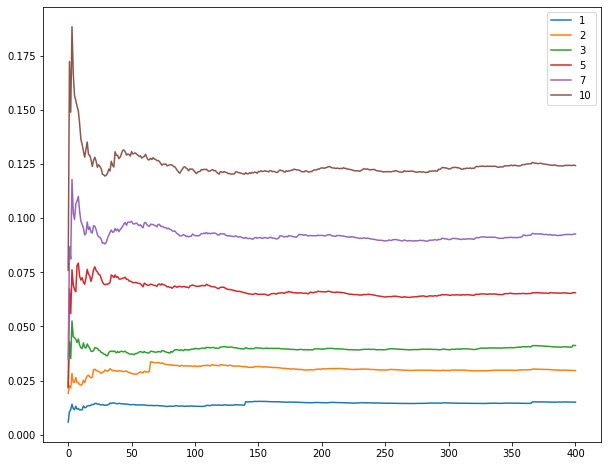

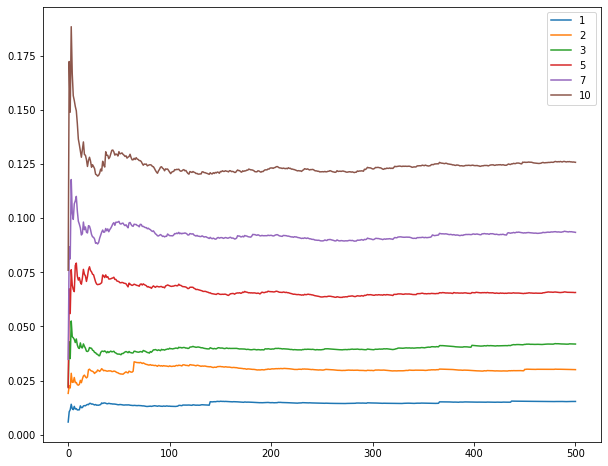

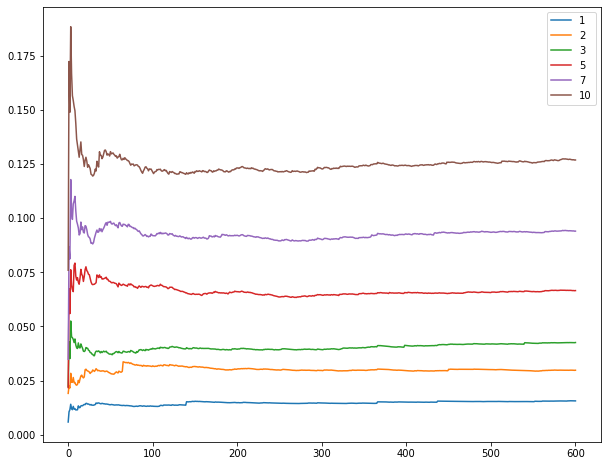

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01555911373838161
2 : 0.029560059658983943
3 : 0.0426170706185814
5 : 0.06726686904076547
7 : 0.0936129865508022
10 : 0.12644754656851181


In [79]:
lstm_model10 = torch.load("models/lstm10/best.ckpt")
all_loss = computeFinalLoss(lstm_model10, test_symbols, 10, [1, 2, 3, 5, 7, 10])

#### Time Horizon = 100, Test Horizons = (1, 5, 10, 25, 50, 75, 100)

In [80]:
lstm_model100 = LSTMModel(100, 128, 4, 7)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(lstm_model100))

618503


In [81]:
train_losses = list()
val_losses = {i: list() for i in [1, 5, 10, 25, 50, 75, 100]}
best_val = [np.inf]

In [82]:
optimizer = optim.Adam(lstm_model100.parameters(), lr = 0.0005)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.17175159481198765
5 : 0.1913729215590264
10 : 0.22414814407594155
25 : 0.2958248045659817
50 : 0.4181100635246963
75 : 0.5827018274577607
100 : 0.7472976306236087
saved checkpoint: 2.631206986619003


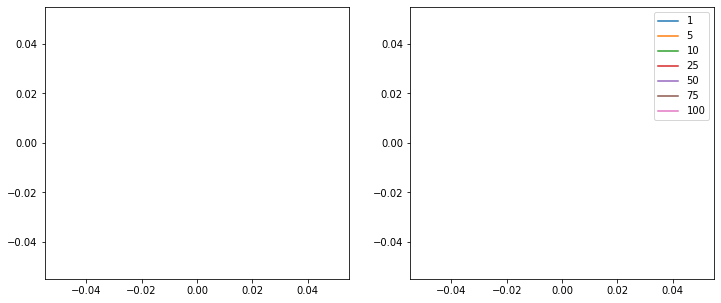

Step: 0... Loss: 4.347751...
Step: 10... Loss: 4.406732...
Step: 20... Loss: 4.199762...
Step: 30... Loss: 3.979806...
Step: 40... Loss: 4.253998...
Step: 50... Loss: 4.045023...
Step: 60... Loss: 4.140171...
Step: 70... Loss: 3.969362...
Step: 80... Loss: 3.780811...
Step: 90... Loss: 3.914148...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.07426469988519276
5 : 0.10101961581210454
10 : 0.12689634578144623
25 : 0.2022483214362825
50 : 0.31219648756130425
75 : 0.4799239697331816
100 : 0.6321790824940088
saved checkpoint: 1.9287285227035207


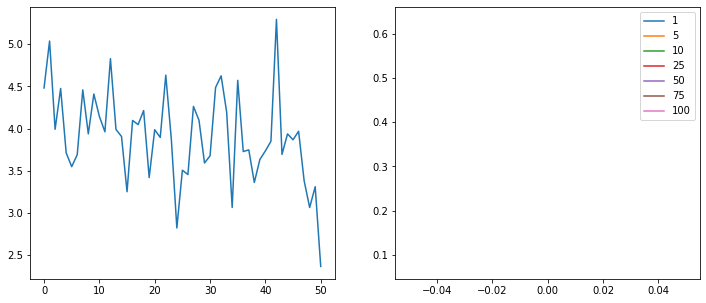

Step: 100... Loss: 3.672238...
Step: 110... Loss: 3.126790...
Step: 120... Loss: 2.931342...
Step: 130... Loss: 2.968731...
Step: 140... Loss: 2.652135...
Step: 150... Loss: 2.675971...
Step: 160... Loss: 2.679794...
Step: 170... Loss: 2.767809...
Step: 180... Loss: 2.683306...
Step: 190... Loss: 2.676491...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.03463516903126882
5 : 0.07091562112917864
10 : 0.10736808866604472
25 : 0.18882478203391617
50 : 0.2876721496628951
75 : 0.4215053022488534
100 : 0.5180880812789266
saved checkpoint: 1.6290091940510834


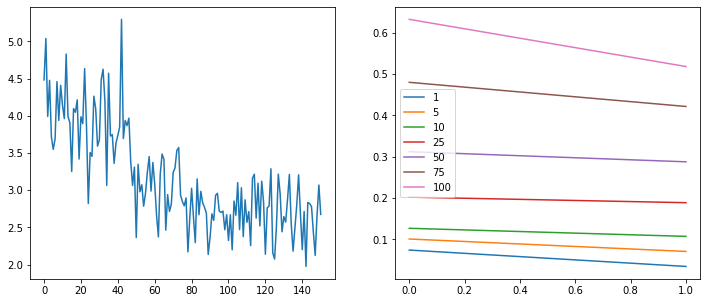

Step: 200... Loss: 2.608668...
Step: 210... Loss: 2.798162...
Step: 220... Loss: 2.705374...
Step: 230... Loss: 2.658546...
Step: 240... Loss: 2.863366...
Step: 250... Loss: 2.616762...
Step: 260... Loss: 2.584003...
Step: 270... Loss: 2.666479...
Step: 280... Loss: 2.779305...
Step: 290... Loss: 2.775095...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.027099669289891205
5 : 0.06355035265893234
10 : 0.0975431416862845
25 : 0.18292336288752237
50 : 0.28020043763527336
75 : 0.38387025112832573
100 : 0.5251317320118478
saved checkpoint: 1.5603189472980772


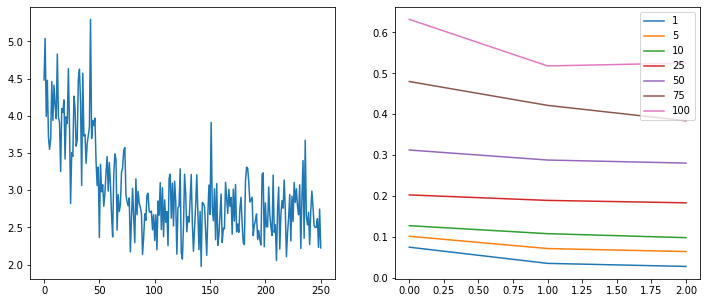

Step: 300... Loss: 2.582229...
Step: 310... Loss: 2.579133...
Step: 320... Loss: 2.526029...
Step: 330... Loss: 2.404221...
Step: 340... Loss: 2.570186...
Step: 350... Loss: 2.523069...
Step: 360... Loss: 2.652727...
Step: 370... Loss: 2.483681...
Step: 380... Loss: 2.675681...
Step: 390... Loss: 2.430425...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.025141388830495742
5 : 0.056415736279731545
10 : 0.09392215786281101
25 : 0.19151211926871625
50 : 0.29158921394079906
75 : 0.3924650517482713
100 : 0.49229138672717615
saved checkpoint: 1.543337054658001


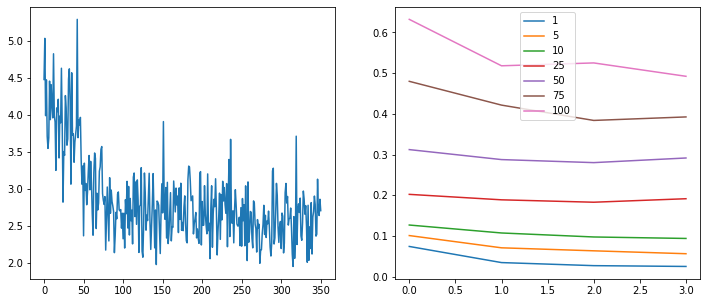

Step: 400... Loss: 2.714752...
Step: 410... Loss: 2.443807...
Step: 420... Loss: 2.713140...
Step: 430... Loss: 2.596694...
Step: 440... Loss: 2.524657...
Step: 450... Loss: 2.558667...
Step: 460... Loss: 2.716344...
Step: 470... Loss: 2.634370...
Step: 480... Loss: 2.543779...
Step: 490... Loss: 2.476649...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.022870193673561873
5 : 0.05633423916069283
10 : 0.0921996559012002
25 : 0.18383046922866464
50 : 0.2859391737170509
75 : 0.4282386069323163
100 : 0.501908593601423


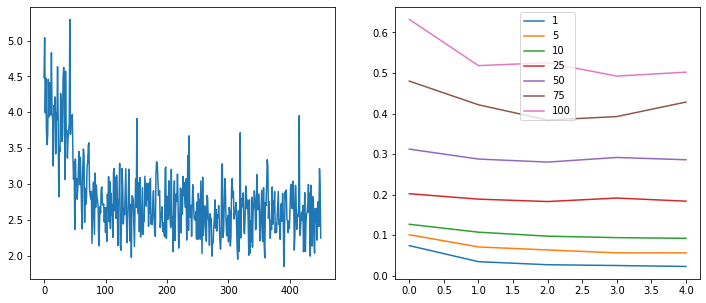

Step: 500... Loss: 2.622087...
Step: 510... Loss: 2.468997...
Step: 520... Loss: 2.692045...
Step: 530... Loss: 2.592177...
Step: 540... Loss: 2.503558...
Step: 550... Loss: 2.598978...
Step: 560... Loss: 2.609030...
Step: 570... Loss: 2.485030...
Step: 580... Loss: 2.517907...
Step: 590... Loss: 2.486896...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.025133176774789105
5 : 0.05826310101627571
10 : 0.09238685039470797
25 : 0.19573551425294444
50 : 0.28654363346299655
75 : 0.3867240437455994
100 : 0.4911299596224697
saved checkpoint: 1.535916279269783


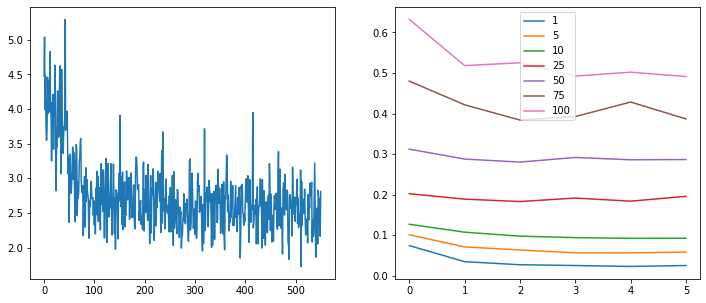

Step: 600... Loss: 2.422745...
Step: 610... Loss: 2.511619...
Step: 620... Loss: 2.722989...
Step: 630... Loss: 2.483626...
Step: 640... Loss: 2.581498...
Step: 650... Loss: 2.672838...
Step: 660... Loss: 2.521018...
Step: 670... Loss: 2.569594...
Step: 680... Loss: 2.555633...
Step: 690... Loss: 2.476123...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.02170805994499074
5 : 0.06068896465112425
10 : 0.10161906616630524
25 : 0.19340373275529263
50 : 0.29349649810026285
75 : 0.42678574676565934
100 : 0.5220442648939894


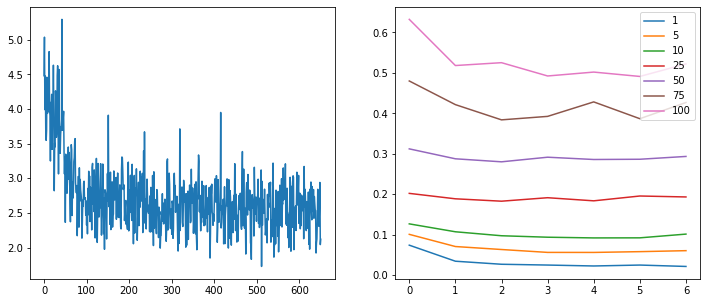

Step: 700... Loss: 2.464708...
Step: 710... Loss: 2.462970...
Step: 720... Loss: 2.512830...
Step: 730... Loss: 2.560260...
Step: 740... Loss: 2.638837...
Step: 750... Loss: 2.600194...
Step: 760... Loss: 2.564534...
Step: 770... Loss: 2.506539...
Step: 780... Loss: 2.351182...
Step: 790... Loss: 2.616536...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.024326859208896583
5 : 0.05662631092013733
10 : 0.09068726250340003
25 : 0.18605019764115746
50 : 0.2994828225732358
75 : 0.4255551467782191
100 : 0.5186132937218029


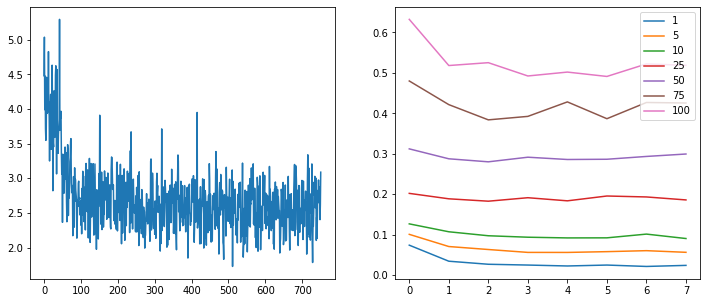

Step: 800... Loss: 2.744389...
Step: 810... Loss: 2.444945...
Step: 820... Loss: 2.523060...
Step: 830... Loss: 2.568633...
Step: 840... Loss: 2.611231...
Step: 850... Loss: 2.399393...
Step: 860... Loss: 2.645186...
Step: 870... Loss: 2.735022...
Step: 880... Loss: 2.549509...
Step: 890... Loss: 2.475439...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.02701537892195327
5 : 0.061589046286953546
10 : 0.0996606195291794
25 : 0.19484835501547748
50 : 0.30988604269756576
75 : 0.43424928224232
100 : 0.5404105654224379


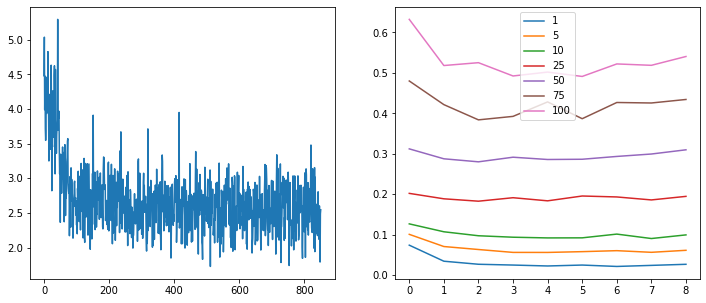

Step: 900... Loss: 2.342295...
Step: 910... Loss: 2.508470...
Step: 920... Loss: 2.457452...
Step: 930... Loss: 2.468188...
Step: 940... Loss: 2.538861...
Step: 950... Loss: 2.370706...


KeyboardInterrupt: 

In [83]:
trainModel(lstm_model100, train_losses, val_losses, best_val, optimizer, 100, [1, 5, 10, 25, 50, 75, 100], 100, "lstm100")

  0%|          | 0/700 [00:00<?, ?it/s]

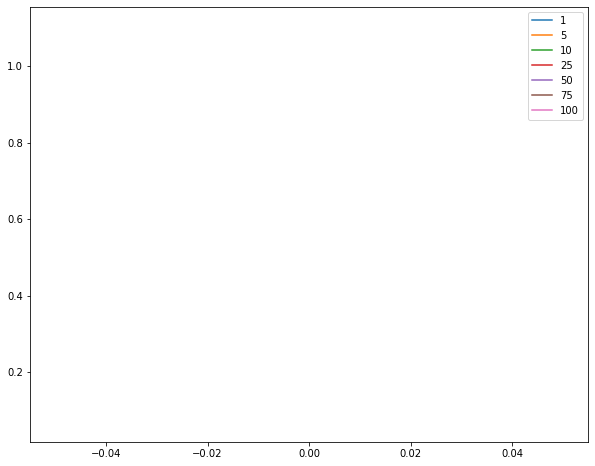

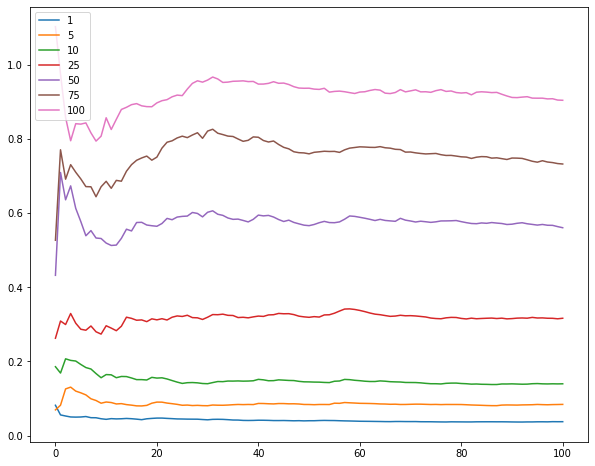

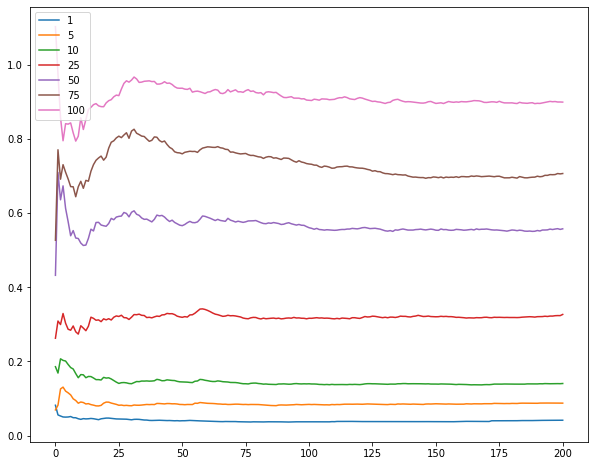

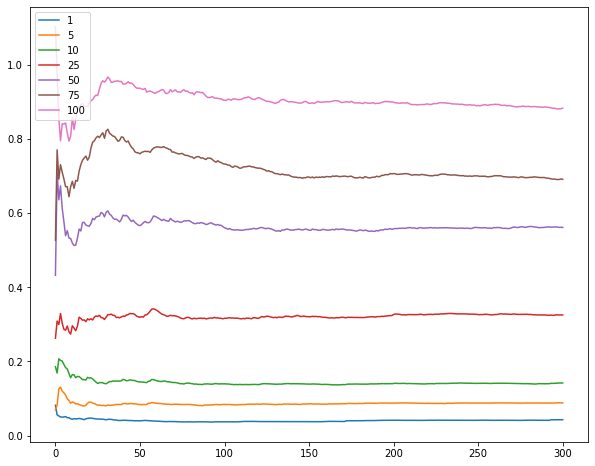

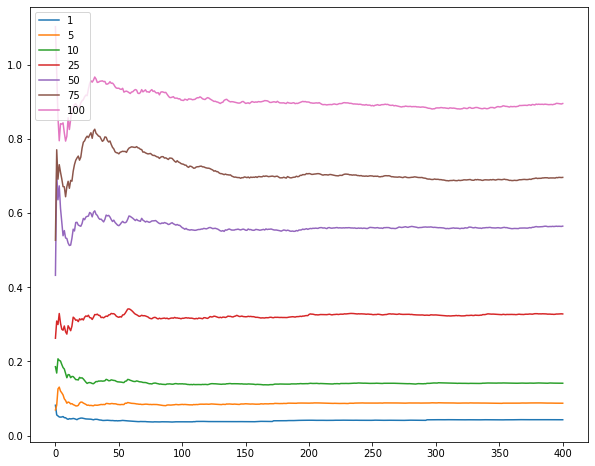

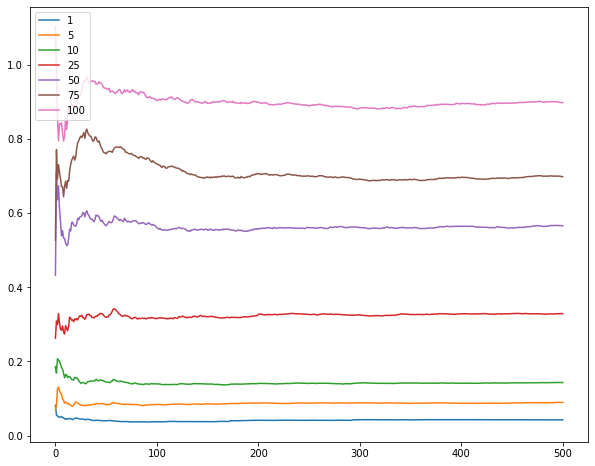

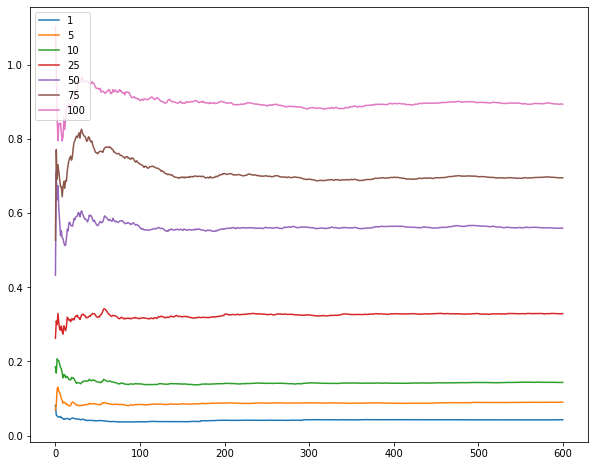

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.04233751228876198
5 : 0.09005088699391411
10 : 0.14259446207247384
25 : 0.3282835576364518
50 : 0.5588981886508211
75 : 0.697728734411752
100 : 0.9004331255428578


In [84]:
lstm_model100 = torch.load("models/lstm100/best.ckpt")
all_loss = computeFinalLoss(lstm_model100, test_symbols, 100, [1, 5, 10, 25, 50, 75, 100])

### Method 7: Transformer

In [90]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, dropout=0.15, max_len=12):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = torch.swapaxes(x, 0, 1)
        x = x + self.pe[:x.size(0)]
        x = torch.swapaxes(x, 0, 1)
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, inp_size, out_size, d_model, n_head, d_hid, n_layers, dropout=0.15):
        super().__init__()
        self.d_model = d_model

        self.encoder = nn.Linear(3, d_model)
        self.pos_encoder = PositionalEncoder(d_model, dropout, inp_size)

        encoder_layers = TransformerEncoderLayer(d_model, n_head, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)

        self.decoder = nn.Linear(d_model * inp_size, 100)
        self.fc = nn.Linear(100, out_size)

    def forward(self, X, X_tweets):
        mean = torch.mean(X, -1).unsqueeze(-1).detach()
        std = torch.std(X, -1).unsqueeze(-1).detach()
            
        X = (X - mean) / std
        X = torch.cat((X.unsqueeze(-1), X_tweets), dim=-1)
        
        enc_src = self.encoder(X) * math.sqrt(self.d_model)
        pos_src = self.pos_encoder(enc_src)
        output = self.transformer_encoder(pos_src)

        out = output.reshape((X.shape[0], X.shape[1] * self.d_model))
        output2 = self.decoder(out)
        f_out = self.fc(output2)
        
        return f_out * std + mean

#### Time Horizon = 10, Test Horizons = (1, 2, 3, 5, 7, 10)

In [91]:
transformer10 = TransformerModel(10, 6, 128, 8, 128, 4)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(transformer10))

527554


In [92]:
train_losses = list()
val_losses = {i: list() for i in [1, 2, 3, 5, 7, 10]}
best_val = [np.inf]

In [95]:
optimizer = optim.Adam(transformer10.parameters(), lr = 0.0001)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01202079994721907
2 : 0.02079908075081586
3 : 0.030388718341693675
5 : 0.04899070448071832
7 : 0.06430081205199738
10 : 0.08445026561764489


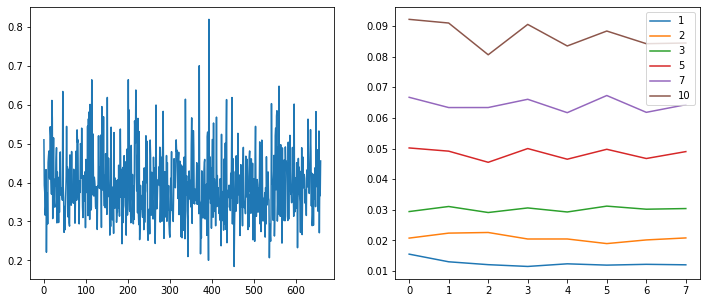

Step: 0... Loss: 0.411659...
Step: 10... Loss: 0.387869...
Step: 20... Loss: 0.393562...
Step: 30... Loss: 0.359732...
Step: 40... Loss: 0.383326...
Step: 50... Loss: 0.381684...
Step: 60... Loss: 0.354208...
Step: 70... Loss: 0.408263...
Step: 80... Loss: 0.315871...
Step: 90... Loss: 0.410365...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.011515454797367377
2 : 0.021477511373523196
3 : 0.029786118079473324
5 : 0.047374603361039554
7 : 0.061191497106787056
10 : 0.08433138170936423


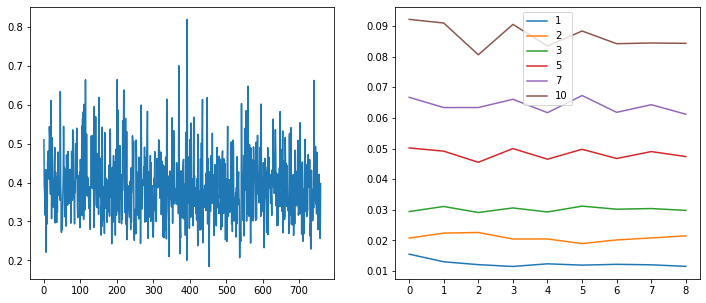

Step: 100... Loss: 0.340150...
Step: 110... Loss: 0.412944...
Step: 120... Loss: 0.339890...
Step: 130... Loss: 0.364207...
Step: 140... Loss: 0.361342...
Step: 150... Loss: 0.393225...
Step: 160... Loss: 0.463177...
Step: 170... Loss: 0.353639...
Step: 180... Loss: 0.366549...
Step: 190... Loss: 0.313127...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01180594937158807
2 : 0.020267566125628803
3 : 0.030707395066051746
5 : 0.048591491890822416
7 : 0.06477477257018532
10 : 0.08428295040856455


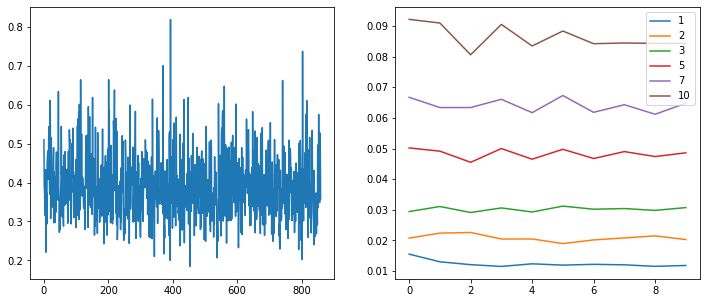

Step: 200... Loss: 0.434214...
Step: 210... Loss: 0.382922...
Step: 220... Loss: 0.397785...
Step: 230... Loss: 0.385110...
Step: 240... Loss: 0.397077...
Step: 250... Loss: 0.366125...
Step: 260... Loss: 0.393701...
Step: 270... Loss: 0.397288...
Step: 280... Loss: 0.411327...
Step: 290... Loss: 0.371259...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.011342960910347978
2 : 0.01940070918573195
3 : 0.02897512382805095
5 : 0.04476751455320102
7 : 0.05875021381892321
10 : 0.0795005002238273
saved checkpoint: 0.2427370225200824


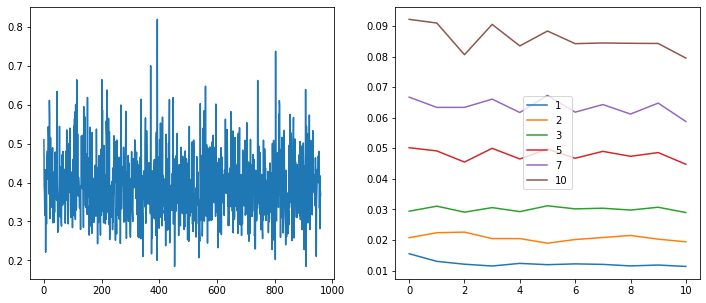

Step: 300... Loss: 0.394362...
Step: 310... Loss: 0.446437...
Step: 320... Loss: 0.371447...
Step: 330... Loss: 0.364970...
Step: 340... Loss: 0.345337...
Step: 350... Loss: 0.426736...
Step: 360... Loss: 0.427370...
Step: 370... Loss: 0.338830...
Step: 380... Loss: 0.342187...
Step: 390... Loss: 0.392878...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.011795823859962095
2 : 0.019726615235594894
3 : 0.02869615054366114
5 : 0.0447634463278546
7 : 0.06354250883261088
10 : 0.08451570865222728


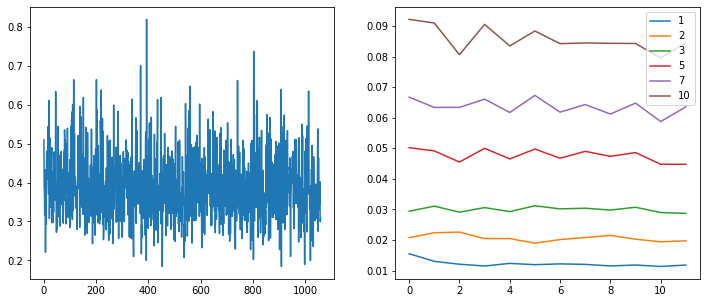

Step: 400... Loss: 0.345049...
Step: 410... Loss: 0.352215...
Step: 420... Loss: 0.411307...


KeyboardInterrupt: 

In [96]:
trainModel(transformer10, train_losses, val_losses, best_val, optimizer, 10, [1, 2, 3, 5, 7, 10], 100, "transformer10")

  0%|          | 0/700 [00:00<?, ?it/s]

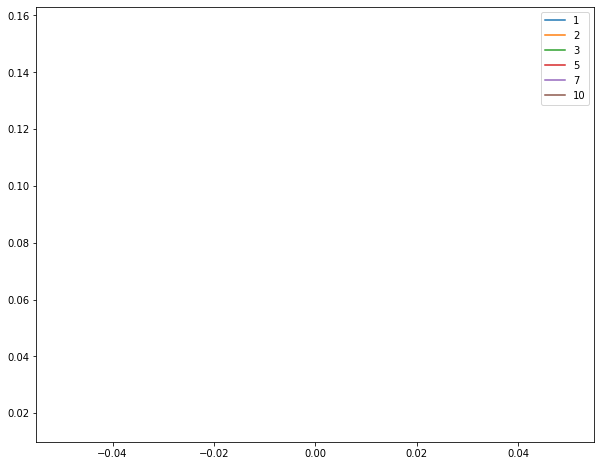

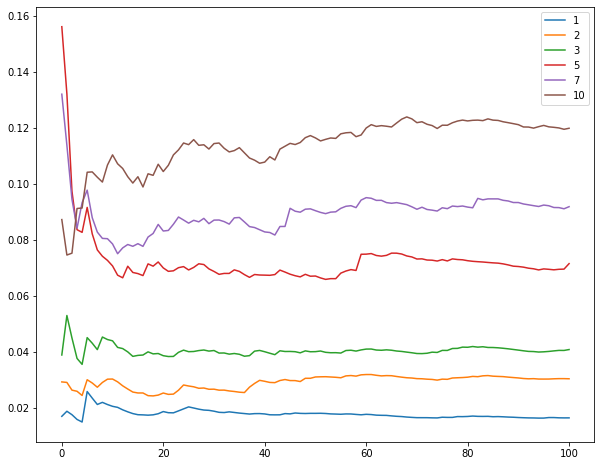

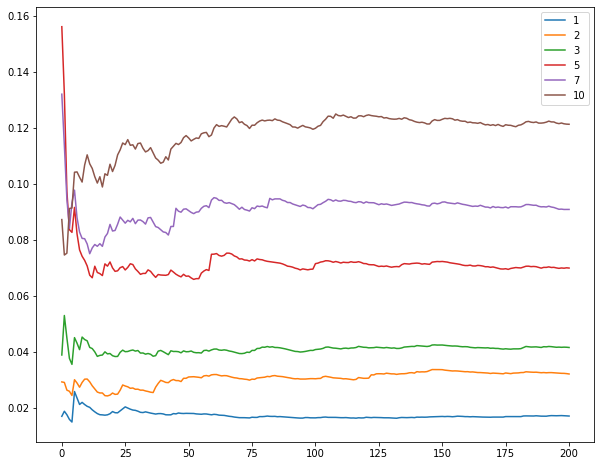

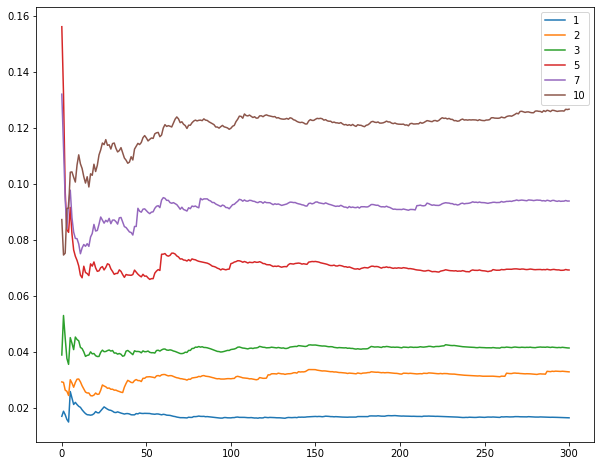

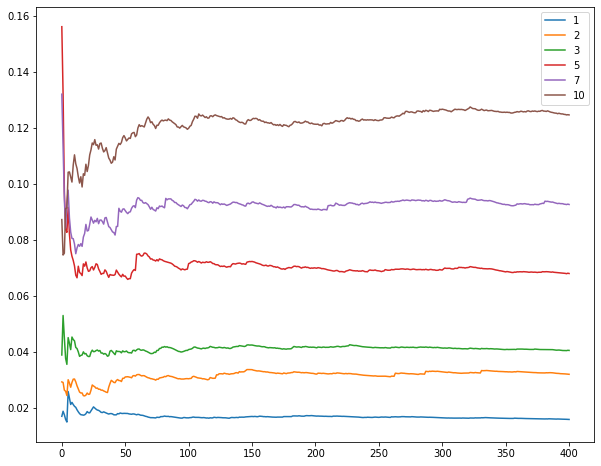

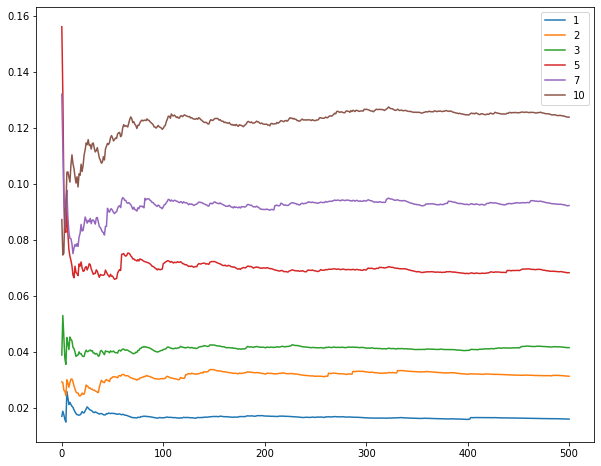

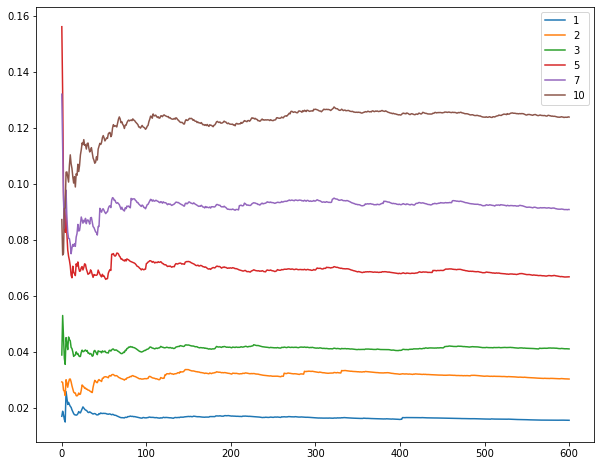

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.015192248859785401
2 : 0.029567465792069352
3 : 0.04047418338635626
5 : 0.06598703602274049
7 : 0.08957978197056293
10 : 0.1224115492659524


In [97]:
transformer10 = torch.load("models/transformer10/best.ckpt")
all_loss = computeFinalLoss(transformer10, test_symbols, 10, [1, 2, 3, 5, 7, 10])

#### Time Horizon = 100, Test Horizons = (1, 5, 10, 25, 50, 75, 100)

In [98]:
transformer100 = TransformerModel(100, 7, 128, 8, 128, 4)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(transformer100))

1679655


In [99]:
train_losses = list()
val_losses = {i: list() for i in [1, 5, 10, 25, 50, 75, 100]}
best_val = [np.inf]

In [102]:
optimizer = optim.Adam(transformer100.parameters(), lr = 0.0001)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.031633327458141555
5 : 0.06592221087930342
10 : 0.1157578243254327
25 : 0.19962113560796366
50 : 0.30569349681994534
75 : 0.49110068699321197
100 : 0.6448395510565488


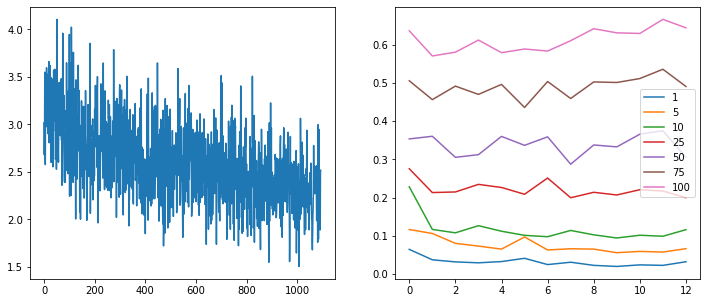

Step: 0... Loss: 2.332528...
Step: 10... Loss: 2.577378...
Step: 20... Loss: 2.539425...
Step: 30... Loss: 2.610047...
Step: 40... Loss: 2.479043...
Step: 50... Loss: 2.590608...
Step: 60... Loss: 2.600347...
Step: 70... Loss: 2.685448...
Step: 80... Loss: 2.410508...
Step: 90... Loss: 2.598898...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.030842503460327998
5 : 0.06723308828865049
10 : 0.11357985696705765
25 : 0.20377241301194768
50 : 0.30551017691979676
75 : 0.505166051198039
100 : 0.6583047934730406


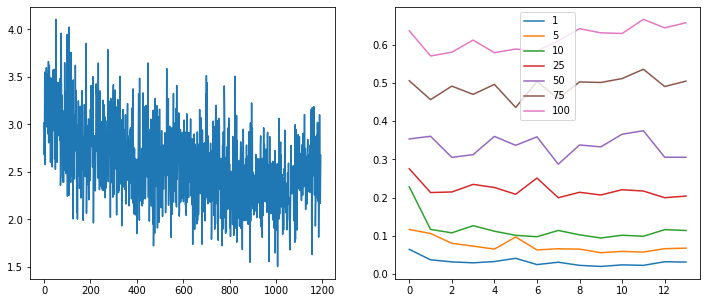

Step: 100... Loss: 2.517597...
Step: 110... Loss: 2.387867...
Step: 120... Loss: 2.464863...
Step: 130... Loss: 2.660194...


KeyboardInterrupt: 

In [105]:
trainModel(transformer100, train_losses, val_losses, best_val, optimizer, 100, [1, 5, 10, 25, 50, 75, 100], 100, "transformer100")

  0%|          | 0/700 [00:00<?, ?it/s]

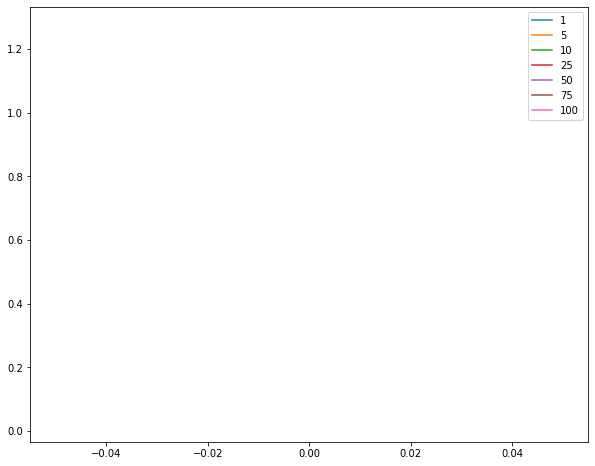

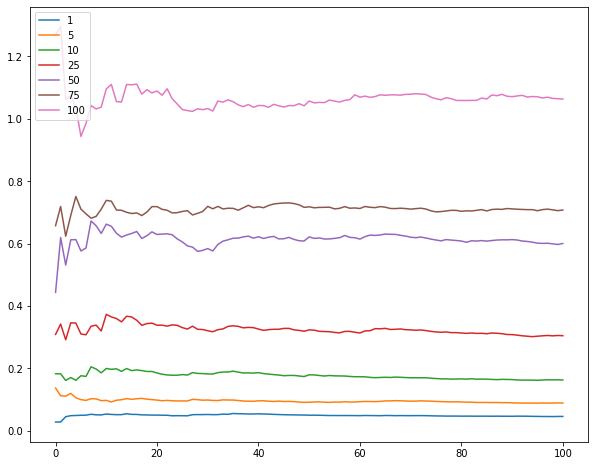

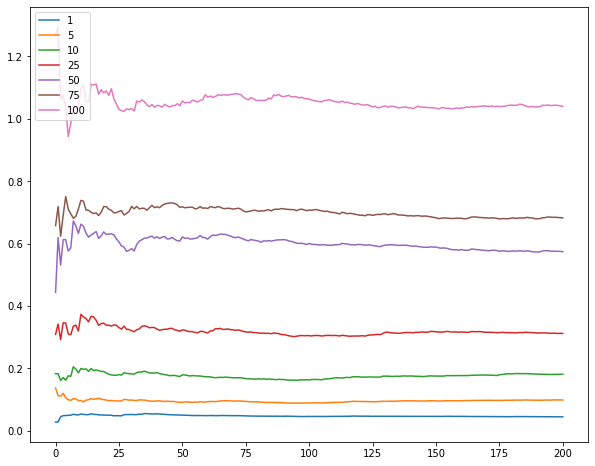

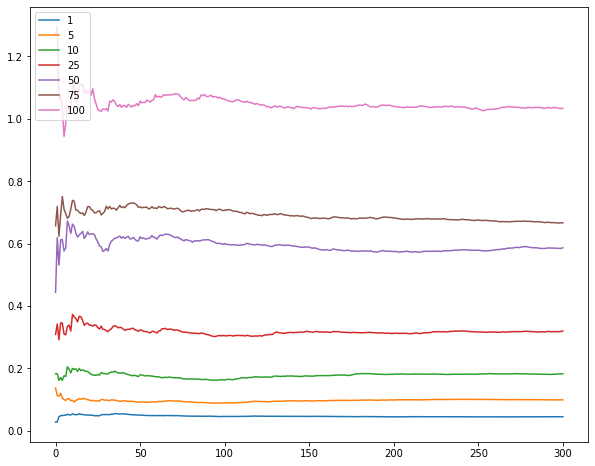

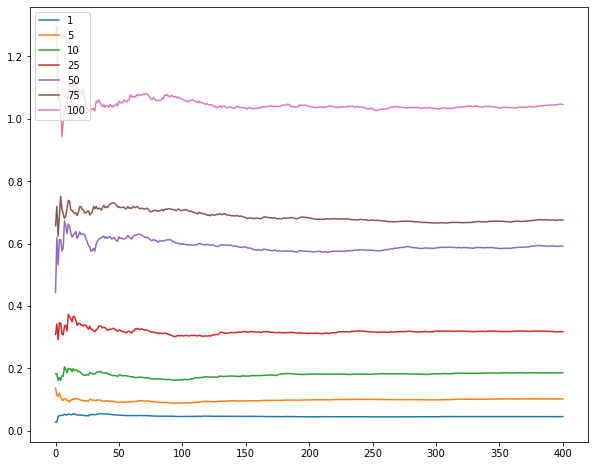

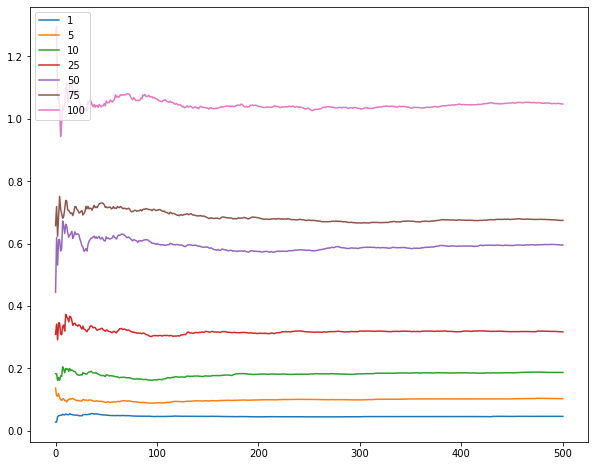

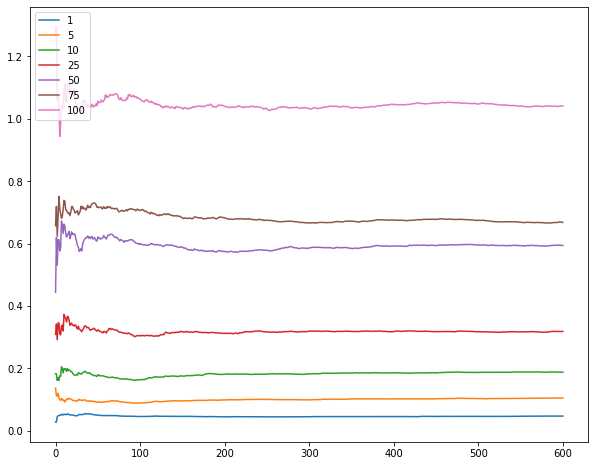

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.04685809086139337
5 : 0.1033420878092241
10 : 0.18738089629693266
25 : 0.3146043030003338
50 : 0.5917631230237865
75 : 0.6679096889223635
100 : 1.0482951772446676


In [104]:
transformer100 = torch.load("models/transformer100/best.ckpt")
all_loss = computeFinalLoss(transformer100, test_symbols, 100, [1, 5, 10, 25, 50, 75, 100])